In [12]:
from netCDF4 import Dataset
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from sklearn.model_selection import train_test_split

with Dataset("obsSSRG_nadir.nc") as fh:
    yobsL=fh["tb"][:,:]
    x2D=fh["iwc_SSRG"][:,:]
    iwc_CS=fh["iwc_CS"][:,:]
    zKu=fh["zKu"][:,:]
    pnorm=fh["pnorm"][:,:]
    pmol=fh["pmol"][:,:]
print(zKu.max())

26.5472389922638


In [20]:

    
pnorm=np.log10(1e-3*(pnorm))
pnormMax=pnorm.max(axis=-1)
nt,nchan=yobsL.shape
lidarEchoPeak=[]
zKuGtL=[]
#print(zKu.shape)
#stop
zKu+=np.random.randn(nt,50)*0.5
zKu[zKu<8]=0
# do pca on zKu
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(zKu)
zKuPC=pca.transform(zKu)
print(zKuPC.shape)
#stop
bscatter=pnorm[:,30:45]
print(zKu.max(axis=0))
for i,pnorm1 in enumerate(pnorm):
    lidarEchoPeak.append([np.argmax(pnorm1)*0.24,2*pnorm1.max()])
    z1=zKu[i]
    a=np.nonzero(z1>8)
    z1[z1<8]=0
    if len(a[0])>0:
        zKuGtL.append(z1)
    else:
        zKuGtL.append(z1)
yobsL+=np.random.randn(nt,nchan)*3
yobsLidarL=np.concatenate((yobsL,np.array(lidarEchoPeak)[:,:],pnorm),axis=-1)
yobsL=np.concatenate((yobsL,np.array(zKuGtL)),axis=-1)
ind_train,ind_test,y_train, y_test = train_test_split(range(nt), x2D[:].sum(axis=-1)*0.24, test_size=0.33, random_state=42)
nt,nc=yobsL.shape
X_train=yobsL[ind_train,:]
X_test=yobsL[ind_test,:]
XLidar_train=yobsL[ind_train,:]
XLidar_test=yobsL[ind_test,:]
iwc_train=x2D[ind_train,:]
iwc_test=x2D[ind_test,:]
iwc_CS_test=iwc_CS[ind_test,:]
zKu_train=zKu[ind_train,:]
zKu_test=zKu[ind_test,:]



(138606, 5)
[ 0.         10.47140229 13.6671481  18.72940924 22.95055134 26.62615873
 25.60116735 25.15135124 26.78684158 26.65935392 25.94744482 23.16615187
 23.61357391 22.87990566 22.81624481 22.62664577 24.58092626 25.68372729
 24.73759918 25.26999305 23.52882586 24.82873797 21.86974992 22.09488508
 19.41446573 19.66312425 19.39699006 19.15659627 18.72136122 17.59046666
 18.93137179 16.44094509 18.82135603 18.22646648 20.52507247 22.26166288
 22.94760858 18.36716066 16.56492992 15.04879086 12.96408848 11.87770103
  8.00669516  0.          0.          0.          0.          0.
  0.          0.        ]


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_60748/3890818634.py:29: UserWarning: Warning: converting a masked element to nan.
  yobsLidarL=np.concatenate((yobsL,np.array(lidarEchoPeak)[:,:],pnorm),axis=-1)


In [19]:
print(np.array(zKuGtL).max(axis=0))

[ 0.          9.76534602 13.17732611 18.37537619 22.58964978 26.48992639
 24.89881412 25.07964099 26.65780474 26.2908402  25.72591155 23.32220993
 23.60627026 23.54625533 22.55717508 22.77054962 24.47641254 25.51471874
 25.10398366 25.5888319  23.95435252 24.7782957  22.49861339 21.64292431
 19.21913627 19.51112476 19.72540777 18.20266881 18.53202076 17.66100492
 17.81576557 16.73875657 18.07611802 18.00736845 20.35576732 21.85138231
 22.32389535 18.63198267 17.12292743 14.96146421 12.55764624 11.01158239
  8.23367921  0.          0.          0.          0.          0.
  0.          0.        ]


In [83]:
print(XLidar_train.shape)

(92866, 21)


In [21]:
nC=18
from sklearn.cluster import KMeans
kmeans_iwc=KMeans(n_clusters=nC, random_state=0).fit(iwc_train)
#define tensorflow classifier in keras. use 2 hidden layers and nc=12 output classes
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import models
from tensorflow.keras import utils

# define the model
X1_train=XLidar_train[:,:]
X1_test=XLidar_test[:,:]
def get_model(nC):
    model = keras.Sequential([
        layers.Dense(30, activation='relu', input_shape=[X1_train.shape[1]]),
        layers.Dense(30, activation='relu'),
        layers.Dense(nC, activation='softmax')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss=losses.CategoricalCrossentropy(),
        metrics=['accuracy'])
    return model


model=get_model(nC)
print(model.summary())
# convert to one-hot encoding
y_train_onehot=utils.to_categorical(kmeans_iwc.labels_)
y_test_onehot=utils.to_categorical(kmeans_iwc.predict(iwc_test))
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X1_train)
X_train_scaled=scaler.transform(X1_train)
X_test_scaled=scaler.transform(X1_test)

print(X_train_scaled.shape)
print(X_test_scaled.mean(axis=0))
print(y_train_onehot.shape)
# train the model
history = model.fit(
    X_train_scaled, y_train_onehot,
    validation_data=(X_test_scaled, y_test_onehot),
    batch_size=32,
    epochs=20,
    verbose=1)

model.save("modelRadiometerRadarClass.h5")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 30)                4650      
                                                                 
 dense_13 (Dense)            (None, 30)                930       
                                                                 
 dense_14 (Dense)            (None, 18)                558       
                                                                 
Total params: 6,138
Trainable params: 6,138
Non-trainable params: 0
_________________________________________________________________
None
(92866, 154)
[ 0.00370356 -0.00150399 -0.00339815 -0.01040943 -0.00516231 -0.00336241
 -0.00519802 -0.00139905 -0.0038409  -0.00907753 -0.00504853 -0.00294843
  0.00262753  0.00252055  0.0044625   0.00976521  0.0061691   0.00681058
  0.00236213  0.00258609  0.00713375  0.00820177  0.00225201 -0.00320709
  0.00

In [32]:
iwpC=[]
kgainL=[]
nx=X_train_scaled.shape[1]
xmL=[]
for i in range(nC):
    iwpC.append(kmeans_iwc.cluster_centers_[i,:].sum()*0.24)
    a=np.nonzero(kmeans_iwc.labels_==i)
    xk=X_train_scaled[a[0],:]
    yk=iwc_train[a[0],:]
    covXY=np.cov(xk.T,yk.T)
    covXX=covXY[:nx,:nx]+0.05*np.eye(nx)
    covYX=covXY[nx:,:nx]
    invCovXX=np.linalg.inv(covXX)
    kgain=np.dot(covYX,invCovXX)
    kgainL.append(kgain)
    xmL.append(np.mean(xk,axis=0))

neigh = KNeighborsRegressor(n_neighbors=30,weights='distance')
neigh.fit(X_train_scaled[:,:4], iwc_train.sum(axis=1)*0.24)
iwp_test_neigh=neigh.predict(X_test_scaled[:,:4])
print(iwpC)

[0.08180295758865695, 0.9089434414931393, 1.6821731655012089, 0.480173359889555, 0.9642660480778134, 1.6737403727582874, 0.23640980883686002, 2.002735531275703, 0.5528023181453682, 0.21693116711461696, 0.5190242172609898, 0.24195421165332084, 1.150682836030796, 3.090464643169096, 0.18547591360809249, 0.9074943865117198, 0.6241187462041996, 1.8092822712470351]


In [33]:
print(covXY.shape)
print(kgainL[0].shape)

(156, 156)
(50, 106)


1430/1430 [==============================] - 0s 342us/step
0.5920479715516944


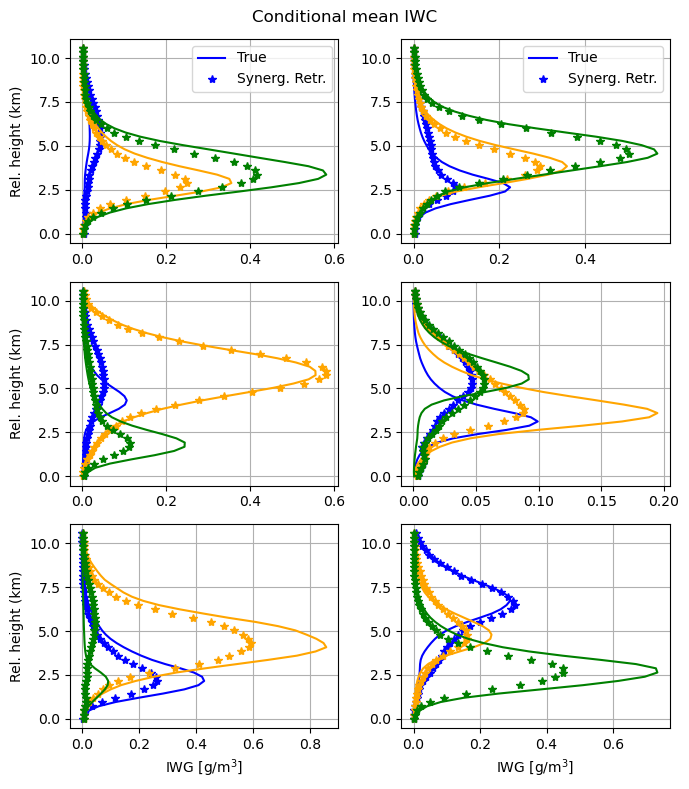

In [36]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

nC=18 # number of clusters

iwc_class_=kmeans_iwc.predict(iwc_test)
plt.figure(figsize=(7,8))

iclass=0
cols=['b','orange','g']

class_onehot_=model.predict(X_test_scaled)
iwcLR_=[]
for i,iwp1_ in enumerate(X_test_scaled):
    iclass=np.argmax(class_onehot_[i,:])
    iwc1=kmeans_iwc.cluster_centers_[iclass,:]+0.975*np.dot(kgainL[iclass],X_test_scaled[i,:]-xmL[iclass])
    iwcLR_.append(iwc1/iwc1.sum()/0.24*iwp_test_neigh[i])
iwcLR_=np.array(iwcLR_)
leg1=['True',None,None]
leg2=['Synerg. Retr.',None,None]
iclass=0
for i in range(3):
    for j in range(2):
        ax=plt.subplot(3,2,i*2+j+1)
        if j>0:
            i1=1
            #ax.yaxis.set_visible(False)
            #ax.set_ylabel('')
        else:
            ax.set_ylabel('Rel. height (km)')
        if i==3:
            ax.set_xlabel('IWG [g/m3]')
        #ax.xaxis.set_visible(False)
        for k in range(3):
            a=np.nonzero(iwc_class_==iclass)[0]
            if len(a)>0:
                plt.plot((iwc_test[a,:45]).mean(axis=0),np.arange(0,45)*0.24,color=cols[k],label=leg1[k])
                plt.plot((iwcLR_[a,:45]).mean(axis=0),np.arange(0,45)*0.24,'*',color=cols[k],label=leg2[k])
                #plt.plot((iwcR_[a,:45]).mean(axis=0),np.arange(0,45)*0.24,'o',color=cols[k])
            # plot yticks no labels
                ax.set_yticks(np.arange(0,12.5,2.5))
                ax.grid()
            iclass+=1
        if i==2:
            ax.set_xlabel('IWG [g/m$^3$]')
        if i==0:
            plt.legend()
            #ax.set_ylabel('Rel. height (km)')
plt.suptitle('Conditional mean IWC')
plt.tight_layout()
plt.savefig('iwcRetrievedClassesSSRGRadiometerRadar.png')
def nrms(iwc1,iwc2):
    return np.sqrt(np.mean((iwc1.flatten()-iwc2.flatten())**2))/np.sqrt(np.mean(iwc1.flatten()**2))
print(nrms(iwc_test,iwcLR_))

(45740, 50)


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_60748/331214034.py:13: RuntimeWarning: invalid value encountered in double_scalars
  hc2=(iwc_test[i,:][a1]*h[a1]).sum()*0.24/iwc_test[i,a1[0]].sum()


[[1.         0.47204593]
 [0.47204593 1.        ]]


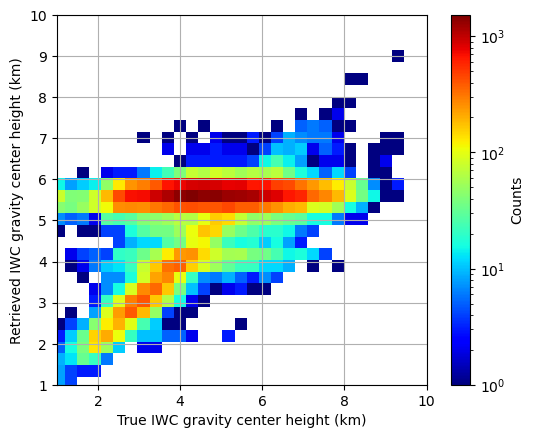

In [34]:
import matplotlib
hgRealL=[]
hgPredL=[]
#print(iwcL_.shape)
print(iwc_test.shape)
for i,iwc1 in enumerate(iwcLR_):
    h=np.arange(50)
    a1=np.nonzero(iwc1>0.01)
    hc1=np.argmax(iwc1)*0.24
    hc2=np.argmax(iwc_test[i,:])*0.24
    if len(a1[0])>3:
        hc1=(iwc1[a1]*h[a1]).sum()*0.24/iwc1[a1].sum()
        hc2=(iwc_test[i,:][a1]*h[a1]).sum()*0.24/iwc_test[i,a1[0]].sum()
    if hc1>0 and hc2>0:
        hgRealL.append(hc2)
        hgPredL.append(hc1)
plt.figure()
ax=plt.subplot(111)
hist2d_=plt.hist2d(hgRealL,hgPredL,bins=30,cmap='jet',norm=matplotlib.colors.LogNorm())
ax.set_aspect('equal')
plt.grid()
plt.xlabel('True IWC gravity center height (km)')
plt.ylabel('Retrieved IWC gravity center height (km)')
plt.xlim(1,10)
plt.ylim(1,10)
cbar=plt.colorbar(hist2d_[-1])
cbar.set_label('Counts')
plt.savefig('radiometerRadar_iwcGcHeight.png')
print(np.corrcoef(hgRealL,hgPredL))

0.3070224346291828 0.3121483114525631


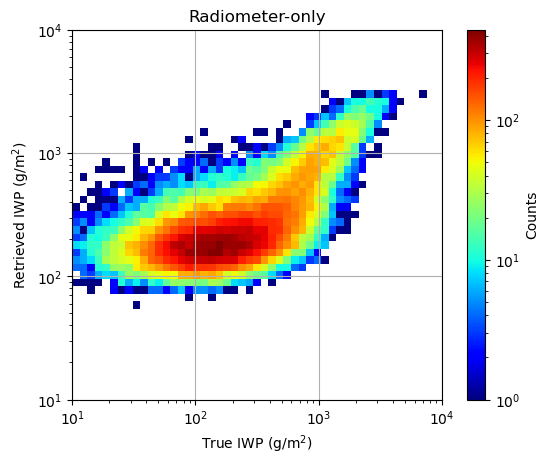

In [35]:
iwcLR_=np.array(iwcLR_)
iwpLR_=np.sum(iwcLR_,axis=1)*0.24
iwp_test_=np.sum(iwc_test,axis=1)*0.24
xbins=np.logspace(1,4,50)
#plt.figure(figsize=(6,6))
ax=plt.subplot(111)
iwp_hist=plt.hist2d(iwp_test_*1000,iwpLR_*1000,bins=xbins,norm=matplotlib.colors.LogNorm(),cmap='jet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("True IWP (g/m$^2$)")
plt.ylabel("Retrieved IWP (g/m$^2$)")
plt.title('Radiometer-only')
ax.set_aspect('equal')
plt.grid()
cbar=plt.colorbar(iwp_hist[-1])
cbar.set_label('Counts')
plt.savefig('radiometerRadar_iwpRetrieval_nadir.png')
print(np.mean(iwpLR_),np.mean(iwp_test_))

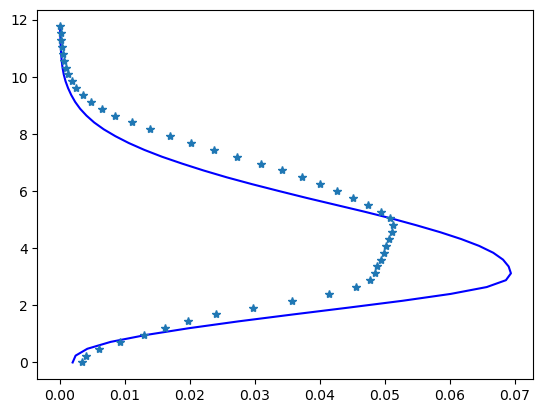

In [31]:
plt.plot(iwc_test.mean(axis=0),np.arange(0,50)*0.24,'b',label='True')
plt.plot(iwcLR_.mean(axis=0),np.arange(0,50)*0.24,'*',label='Retrieved')

In [18]:
print(iwc_.shape)

(92866, 50)
